# 1.0 Importing Libs 

In [1]:
import pandas as pd
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
import os


# 2.0 Downloading Dataset

In [ ]:
import os
import kagglehub

# Create a folder called 'data' in the current directory
data_dir = os.path.join(os.getcwd(), "data")
os.makedirs(data_dir, exist_ok=True)

# Download dataset to 'data' folder
path = kagglehub.dataset_download("gpiosenka/sports-classification", download_dir=data_dir)

print("Path to dataset files:", path)


c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('data/sports.csv')
df

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train
...,...,...,...,...
14488,99,valid/wingsuit flying/1.jpg,wingsuit flying,valid
14489,99,valid/wingsuit flying/2.jpg,wingsuit flying,valid
14490,99,valid/wingsuit flying/3.jpg,wingsuit flying,valid
14491,99,valid/wingsuit flying/4.jpg,wingsuit flying,valid


# 3.0 Loading and Splitting Data 

In [ ]:
from data_utils import load_data

df_train = df[df['data set'] == 'train']
df_valid = df[df['data set'] == 'valid']

X_train, y_train = load_data(df_train)
X_valid, y_valid = load_data(df_valid)


100%|██████████| 500/500 [00:08<00:00, 57.89it/s]


# 4.0 Data Processing 

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)


In [6]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_valid_scaled = scaler.transform(X_valid)


# 5.0 ML Model Trainning - Baseline

In [7]:
from sklearn.decomposition import PCA
import numpy as np

# Optional: ensure memory efficiency
X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)

# PCA with whitening (does mean-centering + variance scaling)
pca = PCA(n_components=500, svd_solver='randomized', whiten=True)

X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)

print("Original shape:", X_train.shape)
print("Reduced shape:", X_train_pca.shape)


Original shape: (13492, 150528)
Reduced shape: (13492, 500)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression(max_iter=1000, verbose=1)
model.fit(X_train_pca, y_train_enc)

y_pred = model.predict(X_valid_pca)
print("Accuracy:", accuracy_score(y_valid_enc, y_pred))
print(classification_report(y_valid_enc, y_pred, target_names=le.classes_))


Accuracy: 0.112
                       precision    recall  f1-score   support

           air hockey       0.00      0.00      0.00         5
      ampute football       0.50      0.20      0.29         5
              archery       0.00      0.00      0.00         5
        arm wrestling       0.43      0.60      0.50         5
         axe throwing       0.50      0.20      0.29         5
         balance beam       0.00      0.00      0.00         5
        barell racing       0.38      0.60      0.46         5
             baseball       0.00      0.00      0.00         5
           basketball       0.00      0.00      0.00         5
       baton twirling       0.00      0.00      0.00         5
            bike polo       0.00      0.00      0.00         5
            billiards       0.50      0.20      0.29         5
                  bmx       0.00      0.00      0.00         5
              bobsled       0.00      0.00      0.00         5
              bowling       0.12      

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score

# Optional: for better performance
X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)

model = SGDClassifier(loss='log_loss',  # logistic regression
                      max_iter=1000,
                      tol=1e-3,
                      n_jobs=-1,        # use all CPU cores
                      random_state=42)

model.fit(X_train, y_train_enc)

y_pred = model.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid_enc, y_pred))
print(classification_report(y_valid_enc, y_pred, target_names=le.classes_))


Accuracy: 0.104
                       precision    recall  f1-score   support

           air hockey       0.00      0.00      0.00         5
      ampute football       0.33      0.20      0.25         5
              archery       0.00      0.00      0.00         5
        arm wrestling       0.27      0.60      0.38         5
         axe throwing       0.50      0.20      0.29         5
         balance beam       0.00      0.00      0.00         5
        barell racing       0.33      0.20      0.25         5
             baseball       0.00      0.00      0.00         5
           basketball       0.00      0.00      0.00         5
       baton twirling       0.00      0.00      0.00         5
            bike polo       0.00      0.00      0.00         5
            billiards       0.67      0.40      0.50         5
                  bmx       0.00      0.00      0.00         5
              bobsled       0.00      0.00      0.00         5
              bowling       0.00      

c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

# 6.0 HOG Approach 

In [1]:
from data_utils import load_data_hog

In [2]:
import pandas as pd

df = pd.read_csv("data/sports.csv")
df_train = df[df["data set"] == "train"]
df_valid = df[df["data set"] == "valid"]

X_train_hog, y_train_hog = load_data_hog(df_train)
X_valid_hog, y_valid_hog = load_data_hog(df_valid)


100%|██████████| 500/500 [00:08<00:00, 58.81it/s]


In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_hog)
y_valid_enc = le.transform(y_valid_hog)


In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score

model = SGDClassifier(
    loss='log_loss',
    max_iter=1000,
    tol=1e-3,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train_hog, y_train_enc)

y_pred = model.predict(X_valid_hog)
print("Accuracy:", accuracy_score(y_valid_enc, y_pred))
print(classification_report(y_valid_enc, y_pred, target_names=le.classes_))


Accuracy: 0.204
                       precision    recall  f1-score   support

           air hockey       0.00      0.00      0.00         5
      ampute football       0.50      0.40      0.44         5
              archery       0.12      0.40      0.19         5
        arm wrestling       0.80      0.80      0.80         5
         axe throwing       0.33      0.20      0.25         5
         balance beam       0.00      0.00      0.00         5
        barell racing       0.67      0.40      0.50         5
             baseball       0.00      0.00      0.00         5
           basketball       0.00      0.00      0.00         5
       baton twirling       0.00      0.00      0.00         5
            bike polo       0.18      0.40      0.25         5
            billiards       0.00      0.00      0.00         5
                  bmx       0.00      0.00      0.00         5
              bobsled       0.00      0.00      0.00         5
              bowling       0.00      

c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Caio Santos\.conda\envs\venv-fproject\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [33]:
## Reload data_utils.py

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


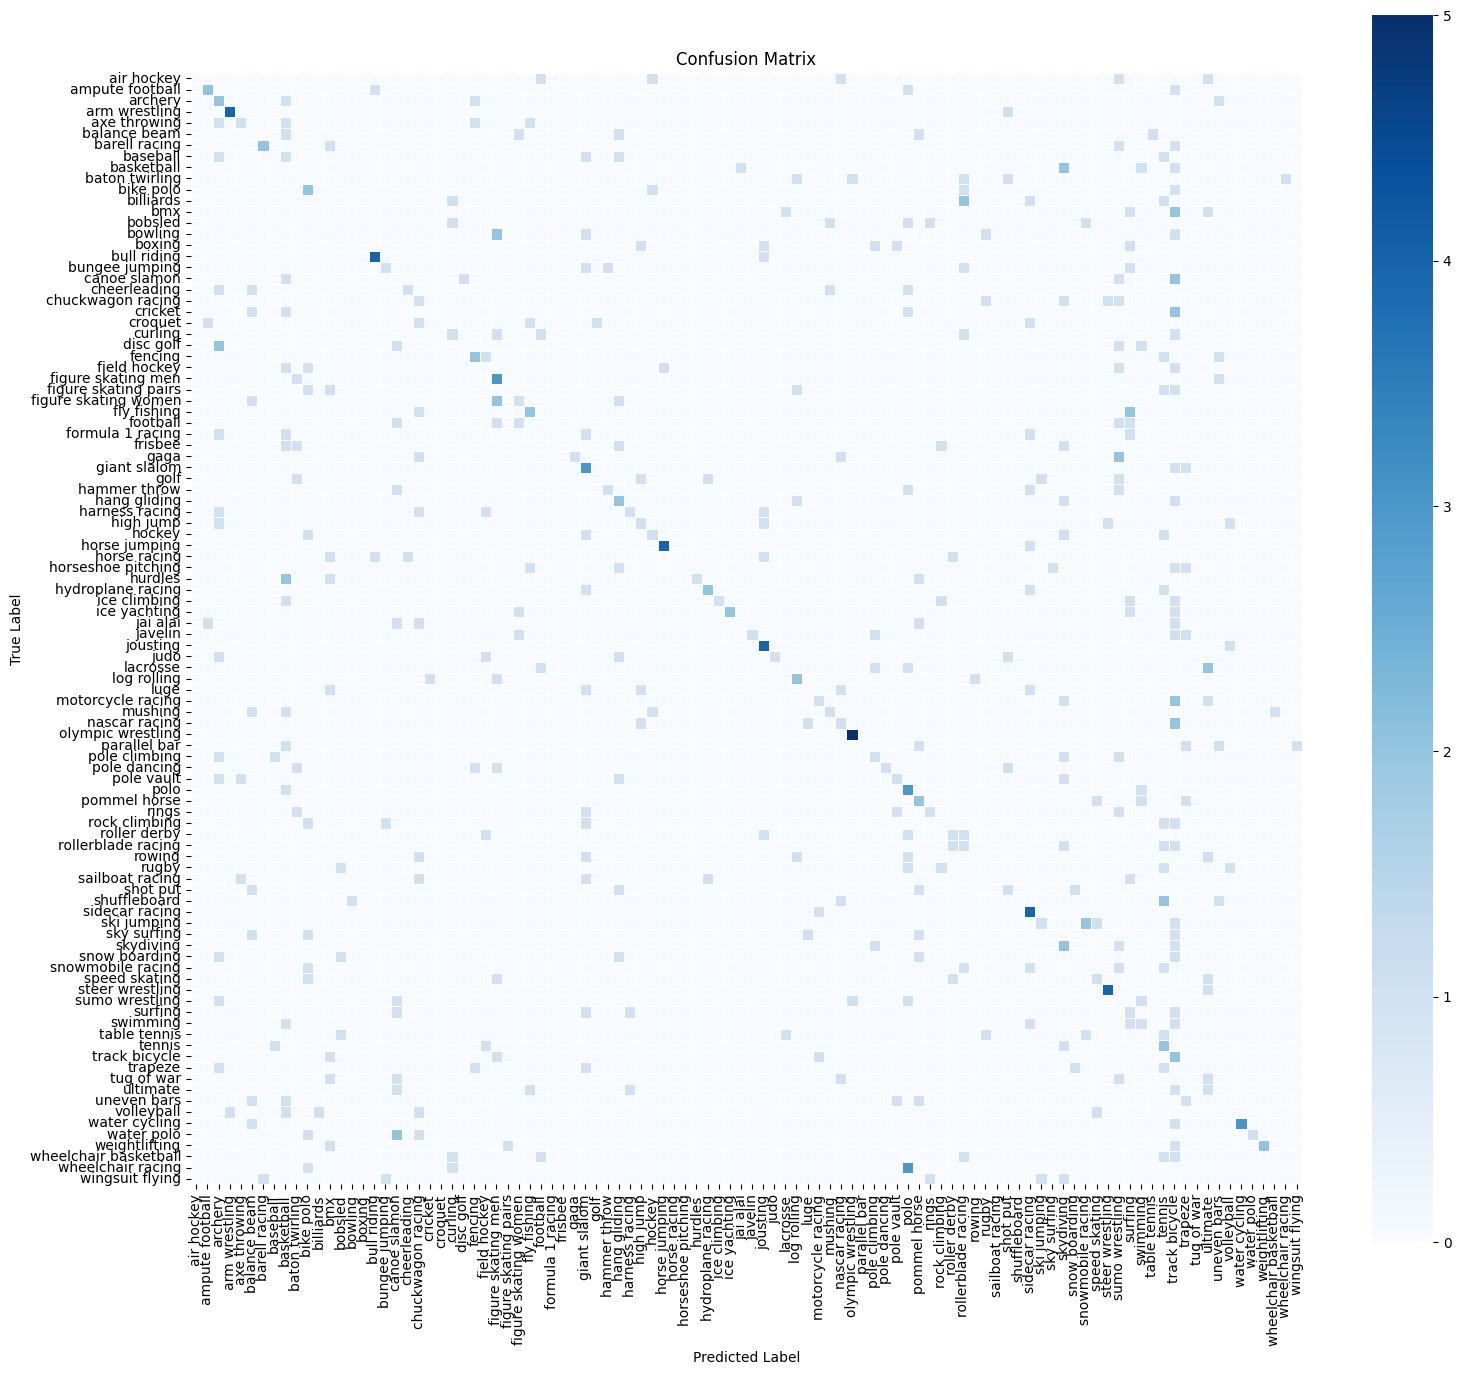

In [35]:
from data_utils import plot_confusion_matrix

plot_confusion_matrix(y_valid_enc, y_pred, class_labels=le.classes_)
